In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from importlib import reload as mreload
import utils
import learn


We load hourly bitcoin data. Use the get_data.py module to download the dataset:

```sh
python get_data.py
```

In [2]:
df = pd.read_csv("data/BTCUSDT_1h_1_Jan_2023_20_May_2025.csv")

df["time"] = pd.to_datetime(df["timestamp"])
df.set_index("time")

df["log_ret"] = np.log(df["close"]).diff()

df = utils.add_rsis(df)

df = df.dropna().reset_index(drop=True)

We added RSI with various window lengths (2-24 hours) as random forests are not time aware. We apply PCA with n_components=4 before training to reduce the dimensionality of the data.

Next train the model on all data. This will overfit. Nevertheless, we will do this to explore how the model works. We set a prediction interval of N = 3 and set the target as the change in log return.

In [3]:
features  = utils.get_features_matrix(df)

N = 3

y_input = df["log_ret"].shift(-N) - df["log_ret"] 

pca, model, y_pred, y = learn.train_rf(features, y_input, N)
signal, up_q, low_q = learn.generate_signals(y_pred, df, N, qmin=0.005, qmax=0.995)

df["signal"] = signal
df["signal"] = df["signal"].rolling(N).mean()


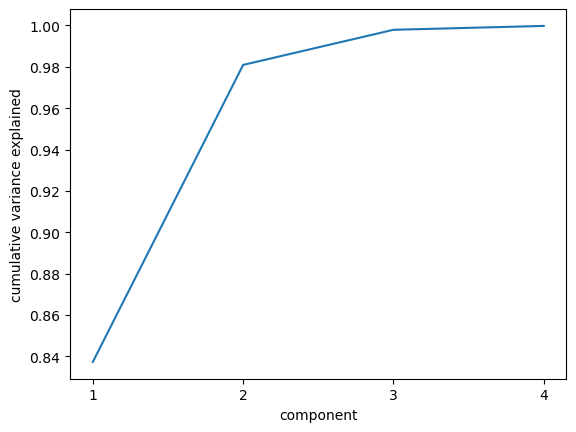

In [4]:
plt.plot(np.arange(1,5), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("component")
plt.ylabel("cumulative variance explained")
plt.xticks(np.arange(1,5));

We can see that the majority of variance is explained by the first four components. The fact that the first principal components explains 84% of all variance suggests that some extra preprocessing could be done.

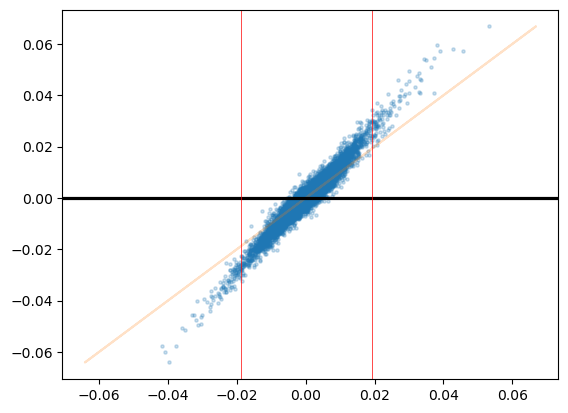

In [5]:
plt.plot(y_pred, y, "o", ms=2.3, alpha=0.23)
plt.plot(y, y, "-", ms=2.3, alpha=0.23)
plt.axhline(y=0, color="k", lw=2.3)
for q in [low_q, up_q]:
    plt.axvline(x=q, color="r", lw=0.5)

We can see that the in sample performance is amazing. The model guesses the change in log price very accurately. 

* long position if model prediction above 0.95 quantile
* short position if model prediction below 0.05 quantile
* We apply a moving average with window of N - this is a fractional signal that allows us to rebalance when new information comes in.

With this in mind, let us conduct a simple backtest to check the model performance

profit factor: 2.749581040439686, sharpe annual: 4.893236048932833


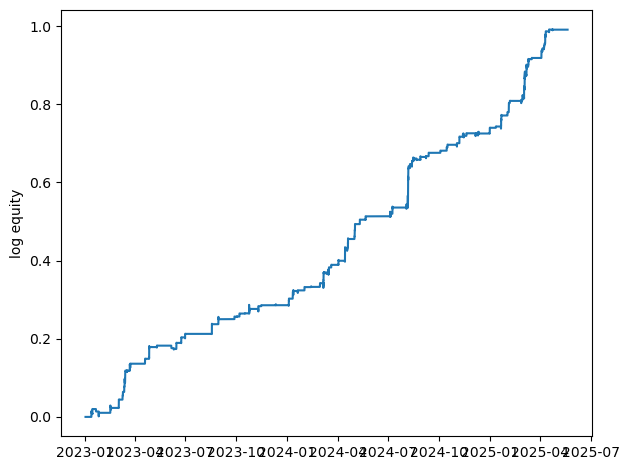

In [9]:

strat_ret, pr, sharpe = utils.compute_returns(df)
df["strat_return"] = strat_ret



plt.plot(df["time"], np.nancumsum(df["strat_return"]))
plt.ylabel("log equity")
plt.tight_layout()


print(f"profit factor: {pr}, sharpe annual: { np.nanmean(strat_ret) * 8760 / (np.nanstd(strat_ret) * np.sqrt(8760)) }")


We can see that the strategy return is exceptionally good.This is because these are in sample predictions. Let us now perform walk-forward validation in order to  have a more realistic output of model performance. We will plot the first 5 out of sample predictions to visualise what is going on.

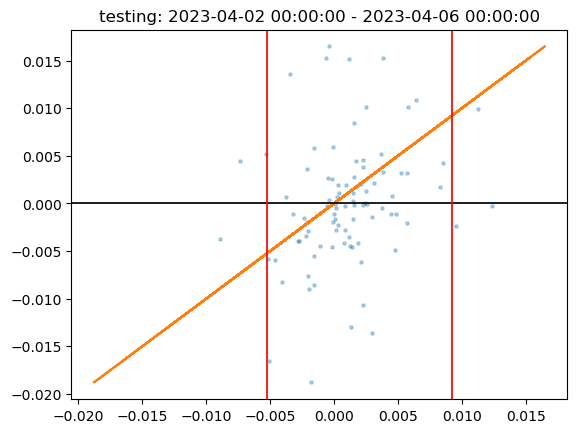

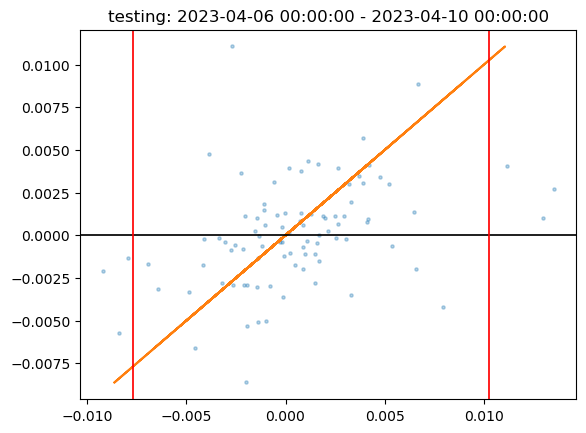

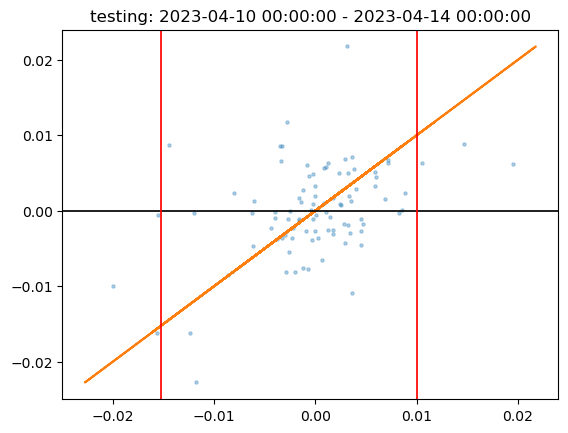

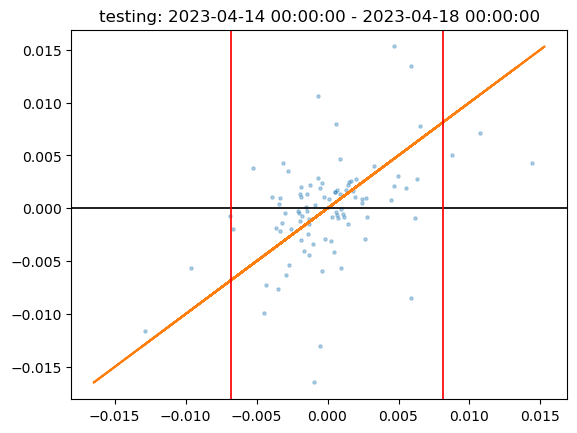

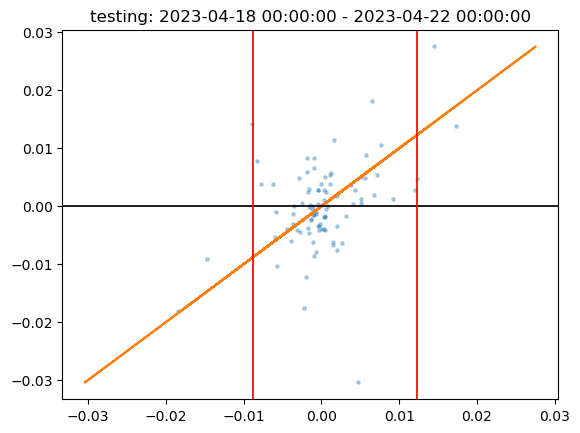

In [7]:
mreload(learn)

train_period = pd.DateOffset(months=3)
test_period = pd.DateOffset(days=4)

final_model, results_list, df_trading = learn.walk_forward(df, train_period, test_period, npca=2, N=4, qmin=0.025, qmax=0.975, plot=True)


without costs:
profit factor: 1.1723906307598095, sharpe: 0.02136379336936537, sharpe ann: 1.9995949785773228
with costs:
profit factor: 0.8860492399054801, sharpe: -0.017181993299511977, sharpe ann: -1.6081894694281984


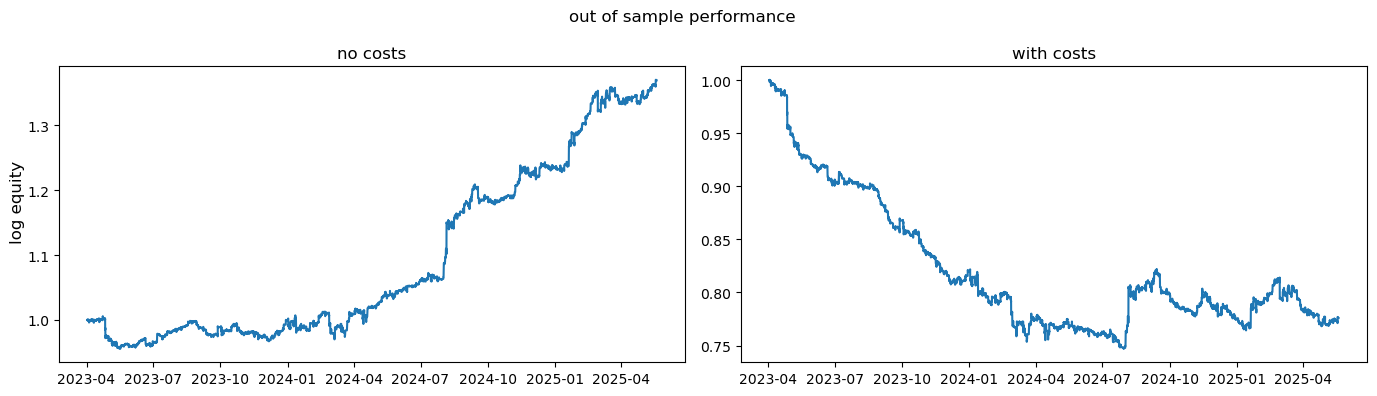

In [8]:


my_ret, pr, sharpe = utils.compute_returns(df_trading, cost=0.00)

my_ret_fees, pr_fees, sharpe_fees = utils.compute_returns(df_trading, cost=0.001)

fig, axs = plt.subplots(1,2, figsize=(14,4))

axs[0].plot(df_trading["time"], np.exp(np.nancumsum(my_ret)))
axs[0].set_title("no costs")

axs[1].plot(df_trading["time"], np.exp(np.nancumsum(my_ret_fees)))
axs[1].set_title("with costs")

fig.supylabel("log equity")
fig.suptitle("out of sample performance")
plt.tight_layout()


print("without costs:")
print(f"profit factor: {pr}, sharpe: {sharpe}, sharpe ann: { np.nanmean(my_ret) * 8760 / (np.nanstd(my_ret) * np.sqrt(8760)) }")
print("with costs:")
print(f"profit factor: {pr_fees}, sharpe: {sharpe_fees}, sharpe ann: { np.nanmean(my_ret_fees) * 8760 / (np.nanstd(my_ret_fees) * np.sqrt(8760)) }")


So our model still performs well out of sample. However, once we take costs into account, the equity curve sinks. Thus we need to take fees and slippage into account. Perhaps we can train a classifier to recognise scenarios when a trade is worth it.
